# Импорты

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Выбор и загрузка данных

In [8]:
df = pd.read_csv('f1_dataset.csv')

# Изучение структуры данных

In [9]:
print(f"Размер датасета: {df.shape}")
print(df.info())
print(df.describe())
print(f"--- Типы данных ---\n{df.dtypes}")
print(f"--- Первые 5 записей ---\n{df.head(5)}")
print(f"--- Последние 5 записей --- \n{df.tail(5)}")

Размер датасета: (1142, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1142 non-null   object 
 1   continent    1142 non-null   object 
 2   grand_prix   1142 non-null   object 
 3   circuit      1142 non-null   object 
 4   winner_name  1142 non-null   object 
 5   team         1142 non-null   object 
 6   time         1142 non-null   object 
 7   laps         1142 non-null   float64
 8   year         1142 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 80.4+ KB
None
              laps         year
count  1142.000000  1142.000000
mean     64.617338  1992.999124
std      20.065139    20.850097
min       1.000000  1950.000000
25%      54.000000  1977.000000
50%      64.000000  1995.000000
75%      72.000000  2011.000000
max     200.000000  2025.000000
--- Типы данных ---
date            object
contin

# Предобработка данных

## Проверка на наличие пропущенных значений

In [36]:
print(df.isnull().sum())

date            0
continent       0
grand_prix      0
circuit         0
winner_name     0
team            0
time            0
laps            0
year            0
time_seconds    0
decade          0
dtype: int64


Исходя из отсутствия пропущенных значений, пропустим этот шаг

## Проверка на наличие дубликатов

In [11]:
print("Количество дубликатов:", df.duplicated().sum())

Количество дубликатов: 0


Исходя из отсутствия дубликатов, пропустим этот шаг

## Анализ выбросов

In [12]:
num_cols = df.select_dtypes(include=[np.number]).columns

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

mask = ~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
print("Удалено выбросов:", (~mask).sum())

df = df[mask]


Удалено выбросов: 65


## Преобразование типов данных

In [13]:
df['date'] = pd.to_datetime(df['date'])

def time_to_seconds(t):
    if str(t).count(':') == 2:
        h, m, s = map(int, str(t).split(':'))
        return h * 3600 + m * 60 + s
    elif str(t).count(':') == 1:
        m, s = map(int, str(t).split(':'))
        return m * 60 + s
    return np.nan

df['time_seconds'] = df['time'].apply(time_to_seconds)

print("Типы данных после преобразования:")
print(df[['date', 'time_seconds']].dtypes)
df[['date', 'time', 'time_seconds']].head()

Типы данных после преобразования:
date            datetime64[ns]
time_seconds             int64
dtype: object


,date,time,time_seconds
0,1950-05-13,02:13:23,8003
3,1950-06-04,02:02:53,7373
4,1950-06-18,02:47:26,10046
5,1950-07-02,02:57:52,10672
6,1950-09-03,02:51:17,10277


## Создание новых переменных

Была создана переменная ```decade``` для анализа трендов в различных эпохи Формулы-1




In [14]:
df['decade'] = (df['year'] // 10) * 10
df[['year', 'decade']].head(10)

,year,decade
0,1950,1950
3,1950,1950
4,1950,1950
5,1950,1950
6,1950,1950
7,1951,1950
9,1951,1950
10,1951,1950
11,1951,1950
12,1951,1950


# Предобработка признаков

In [37]:
df = pd.get_dummies(df, columns=['continent', 'grand_prix', 'circuit', 'team', 'winner_name'], drop_first=True)
df['year_log'] = np.log1p(df['year'])
df['laps_log'] = np.log1p(df['laps'])
df['laps_per_year'] = df['laps'] / df['year']

# Разделение данных и масштабирование

In [38]:
X = df.drop(columns=['time', 'date', 'time_seconds'])
y = df['time_seconds']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Функция оценки моделей

In [39]:
def eval_model(m, Xtr, ytr, Xte, yte, name):
    m.fit(Xtr, ytr)
    yp_tr, yp_te = m.predict(Xtr), m.predict(Xte)
    return pd.DataFrame({
        'model': [name],
        'MAE': [mean_absolute_error(yte, yp_te)],
        'MSE': [mean_squared_error(yte, yp_te)],
        'RMSE': [np.sqrt(mean_squared_error(yte, yp_te))],
        'R2': [r2_score(yte, yp_te)]
    })

res = pd.DataFrame()

# Обучение всех моделей

## Линейная регрессия

In [40]:
res = pd.concat([res, eval_model(LinearRegression(), X_train_scaled, y_train, X_test_scaled, y_test, 'Linear')])

## Полиномиальная регрессия

In [41]:
poly = PolynomialFeatures(2)
Xtr_p, Xte_p = poly.fit_transform(X_train_scaled), poly.transform(X_test_scaled)
res = pd.concat([res, eval_model(LinearRegression(), Xtr_p, y_train, Xte_p, y_test, 'Poly2')])


## Ridge и Lasso

In [42]:
res = pd.concat([
    res,
    eval_model(Ridge(alpha=1.0), X_train_scaled, y_train, X_test_scaled, y_test, 'Ridge'),
    eval_model(Lasso(alpha=0.001, max_iter=10000), X_train_scaled, y_train, X_test_scaled, y_test, 'Lasso')
])

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.200e+08, tolerance: 1.359e+05
  model = cd_fast.enet_coordinate_descent(


## Случайный лес и градиентный бустинг

In [43]:
res = pd.concat([
    res,
    eval_model(RandomForestRegressor(n_estimators=200, random_state=42), X_train_scaled, y_train, X_test_scaled, y_test, 'RF'),
    eval_model(GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42), X_train_scaled, y_train, X_test_scaled, y_test, 'GBR')
])

# Сравнение результатов

In [44]:
res = res.sort_values('RMSE').reset_index(drop=True)
display(res)

,model,MAE,MSE,RMSE,R2
0,RF,4.254607e+02,7.404841e+05,8.605138e+02,6.677100e-01
1,GBR,5.012182e+02,7.860676e+05,8.866045e+02,6.472546e-01
2,Linear,5.354046e+02,9.734966e+05,9.866593e+02,5.631464e-01
3,Ridge,5.415203e+02,1.015852e+06,1.007895e+03,5.441395e-01
4,Lasso,5.560766e+02,1.066427e+06,1.032680e+03,5.214441e-01
5,Poly2,1.025428e+09,7.115344e+18,2.667460e+09,-3.192989e+12


# Анализ важности признаков

<Axes: >

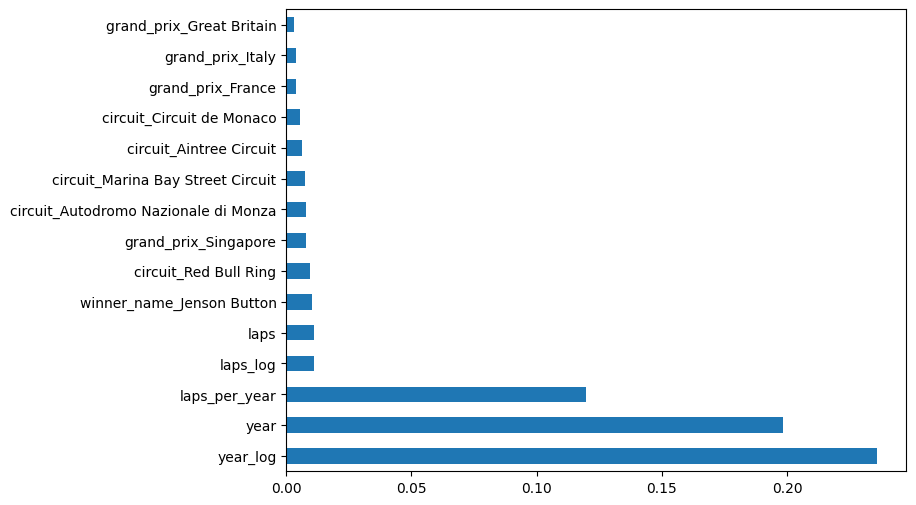

In [46]:
best_name = res.iloc[0]['model']
models = {
    'Linear': LinearRegression(),
    'Poly2': LinearRegression().fit(Xtr_p, y_train),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001, max_iter=10000),
    'RF': RandomForestRegressor(n_estimators=200, random_state=42),
    'GBR': GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
}
best = models[best_name]
best.fit(X_train_scaled, y_train)
imp = permutation_importance(best, X_test_scaled, y_test, n_repeats=10, random_state=42)
pd.Series(imp.importances_mean, index=X.columns).nlargest(15).plot(kind='barh', figsize=(8,6))

In [50]:
best

RandomForestRegressor(n_estimators=200, random_state=42)

# Сравнение предсказаний

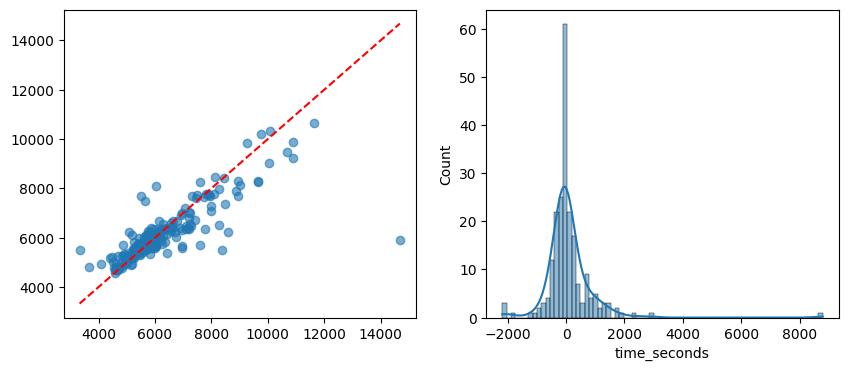

In [47]:
yp = best.predict(X_test_scaled)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_test, yp, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.subplot(1,2,2)
sns.histplot(y_test - yp, kde=True)
plt.show()

# Тюнинг и ансамбли

In [48]:
grid = {
    'RF': {'n_estimators':[100,200],'max_depth':[None,10,20]},
    'GBR': {'n_estimators':[100,200],'learning_rate':[0.01,0.05],'max_depth':[3,5]}
}
best_rf = GridSearchCV(RandomForestRegressor(random_state=42), grid['RF'], cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train_scaled, y_train).best_estimator_
best_gbr = GridSearchCV(GradientBoostingRegressor(random_state=42), grid['GBR'], cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train_scaled, y_train).best_estimator_
res = pd.concat([
    res,
    eval_model(best_rf, X_train_scaled, y_train, X_test_scaled, y_test, 'RF_tuned'),
    eval_model(best_gbr, X_train_scaled, y_train, X_test_scaled, y_test, 'GBR_tuned')
])
display(res.sort_values('RMSE'))

,model,MAE,MSE,RMSE,R2
0,RF,4.254607e+02,7.404841e+05,8.605138e+02,6.677100e-01
0,RF_tuned,4.254607e+02,7.404841e+05,8.605138e+02,6.677100e-01
0,GBR_tuned,4.767800e+02,7.740859e+05,8.798215e+02,6.526313e-01
1,GBR,5.012182e+02,7.860676e+05,8.866045e+02,6.472546e-01
2,Linear,5.354046e+02,9.734966e+05,9.866593e+02,5.631464e-01
3,Ridge,5.415203e+02,1.015852e+06,1.007895e+03,5.441395e-01
4,Lasso,5.560766e+02,1.066427e+06,1.032680e+03,5.214441e-01
5,Poly2,1.025428e+09,7.115344e+18,2.667460e+09,-3.192989e+12


In [49]:
stack = StackingRegressor(
    estimators=[('rf', best_rf), ('gbr', best_gbr), ('lr', LinearRegression())],
    final_estimator=Ridge(), n_jobs=-1
)
res = pd.concat([res, eval_model(stack, X_train_scaled, y_train, X_test_scaled, y_test, 'Stacking')])
display(res.sort_values('RMSE'))

,model,MAE,MSE,RMSE,R2
0,RF,4.254607e+02,7.404841e+05,8.605138e+02,6.677100e-01
0,RF_tuned,4.254607e+02,7.404841e+05,8.605138e+02,6.677100e-01
0,Stacking,4.482153e+02,7.453742e+05,8.633506e+02,6.655156e-01
0,GBR_tuned,4.767800e+02,7.740859e+05,8.798215e+02,6.526313e-01
1,GBR,5.012182e+02,7.860676e+05,8.866045e+02,6.472546e-01
2,Linear,5.354046e+02,9.734966e+05,9.866593e+02,5.631464e-01
3,Ridge,5.415203e+02,1.015852e+06,1.007895e+03,5.441395e-01
4,Lasso,5.560766e+02,1.066427e+06,1.032680e+03,5.214441e-01
5,Poly2,1.025428e+09,7.115344e+18,2.667460e+09,-3.192989e+12
